<a href="https://colab.research.google.com/github/fsmox/WJDRAI/blob/main/WJDRAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import os
import re

In [8]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
from Model import CaptureDataset, ResizePad,ClickPredictionModel

In [ ]:
DataFolder = 'drive/MyDrive/AIData'

In [ ]:
# prompt: 从本地上传数据（data.7z）到工作空间,并解压到data文件夹

!pip install py7zr

import py7zr

# 上传数据
from google.colab import files
uploaded = files.upload()

# 解压到data文件夹
for fn in uploaded.keys():
  if fn.endswith('.7z'):
    with py7zr.SevenZipFile(fn, mode='r') as z:
      z.extractall(path=DataFolder)
      print(f'文件 {fn} 解压到 data 文件夹.')


Saving Data.7z to Data.7z
文件 Data.7z 解压到 data 文件夹.


In [ ]:
def DataLoderTest():
    # 获取当前脚本所在目录，并拼接 Capture 文件夹路径
    # current_dir = os.path.dirname(os.path.abspath(__file__))
    current_dir = os.getcwd()
    capture_folder = os.path.join(current_dir, DataFolder)
    capture_folder = os.path.join(capture_folder, "Data")

    # 定义图像预处理（调整尺寸和归一化，符合 ResNet50 要求）
    transform = transforms.Compose([
        ResizePad((224, 224), fill=(0, 0, 0)),  # 使用黑色填充
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])

    # 初始化 Dataset 和 DataLoader
    dataset = CaptureDataset(root_dir=capture_folder, transform=transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

    # 测试 DataLoader 是否正确加载数据
    for images, inputs, targets in dataloader:
        print("Image batch shape:", images.shape)   # 应为 (batch_size, 3, 224, 224)
        print("Input params shape:", inputs.shape)    # 应为 (batch_size, 4)
        print("Target shape:", targets.shape)         # 应为 (batch_size, 4)

        # 反归一化图像数据
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        img = images[0] * std[:, None, None] + mean[:, None, None]
        img = img.permute(1, 2, 0).numpy()  # 调整维度顺序以适应 matplotlib
        img = (img * 255).astype('uint8')  # 转换为 uint8 类型
        plt.imshow(img)
        plt.show()
        break

In [ ]:
def main():
    # 检查设备
    use_cuda = torch.cuda.is_available()
    use_mps = torch.backends.mps.is_available()
    if use_cuda:
        device = torch.device("cuda")
        print("Using CUDA")
    elif use_mps:
        device = torch.device("mps")
        print("Using MPS")
    else:
        device = torch.device("cpu")
        print("Using CPU")

    # 获取当前脚本所在目录，并拼接 Capture 文件夹路径
    # current_dir = os.path.dirname(os.path.abspath(__file__))
    current_dir = os.getcwd()
    capture_folder = os.path.join(current_dir, DataFolder, "Data")

    # 定义图像预处理（调整尺寸和归一化，符合 ResNet50 要求）
    transform = transforms.Compose([
        ResizePad((224, 224), fill=(0, 0, 0)),  # 使用黑色填充
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])

    # 初始化 Dataset 和 DataLoader
    dataset = CaptureDataset(root_dir=capture_folder, transform=transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

    # 创建模型
    model = ClickPredictionModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # 读取模型
    if os.path.exists("click_prediction_model.pth"):
        model.load_state_dict(torch.load("click_prediction_model.pth", map_location=device))

    # 训练模型
    epochs = 5
    loss_fn = nn.SmoothL1Loss()
    for epoch in range(epochs):
        for img, input_xy, target_xy in dataloader:
            img, input_xy, target_xy = img.to(device), input_xy.to(device), target_xy.to(device)
            optimizer.zero_grad()
            output_xy = model(img, input_xy)
            loss = loss_fn(output_xy, target_xy)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        # 保存模型
        torch.save(model.state_dict(), "click_prediction_model.pth")


Image batch shape: torch.Size([32, 3, 224, 224])
Input params shape: torch.Size([32, 4])
Target shape: torch.Size([32, 2])


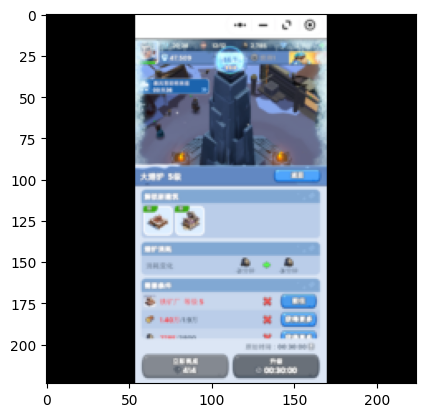

In [ ]:
DataLoderTest()

In [ ]:
# 检查设备
use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()
if use_cuda:
  device = torch.device("cuda")
  print("Using CUDA")
elif use_mps:
  device = torch.device("mps")
  print("Using MPS")
else:
  device = torch.device("cpu")
  print("Using CPU")

# 获取当前脚本所在目录，并拼接 Capture 文件夹路径
# current_dir = os.path.dirname(os.path.abspath(__file__))
current_dir = os.getcwd()
capture_folder = os.path.join(current_dir, DataFolder, "Data")

# 定义图像预处理（调整尺寸和归一化，符合 ResNet50 要求）
transform = transforms.Compose([
    ResizePad((224, 224), fill=(0, 0, 0)),  # 使用黑色填充
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# 初始化 Dataset 和 DataLoader
dataset = CaptureDataset(root_dir=capture_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

# 创建模型
model = ClickPredictionModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

modle_path = os.path.join(DataFolder,"click_prediction_model.pth")

# 读取模型
if os.path.exists(modle_path):
  model.load_state_dict(torch.load(modle_path, map_location=device))

# 训练模型
epochs = 100
loss_fn = nn.SmoothL1Loss()

for epoch in range(epochs):
  for img, input_xy, target_xy in dataloader:
    img, input_xy, target_xy = img.to(device), input_xy.to(device), target_xy.to(device)
    optimizer.zero_grad()
    output_xy = model(img, input_xy)
    loss = loss_fn(output_xy, target_xy)
    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch}, Loss: {loss.item()}")
  # 保存模型
  torch.save(model.state_dict(), modle_path)

Using CUDA


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0, Loss: 426.48748779296875
Epoch 1, Loss: 341.83404541015625
Epoch 2, Loss: 276.07720947265625
Epoch 3, Loss: 191.48948669433594
Epoch 4, Loss: 115.88409423828125
Epoch 5, Loss: 36.12302780151367
Epoch 6, Loss: 24.980363845825195
Epoch 7, Loss: 23.964702606201172
Epoch 8, Loss: 31.800086975097656
Epoch 9, Loss: 22.753650665283203
Epoch 10, Loss: 38.48667907714844
Epoch 11, Loss: 17.717016220092773
Epoch 12, Loss: 17.320316314697266
Epoch 13, Loss: 23.406129837036133
Epoch 14, Loss: 18.258045196533203
Epoch 15, Loss: 15.55550765991211
Epoch 16, Loss: 28.362491607666016
Epoch 17, Loss: 17.143417358398438
Epoch 18, Loss: 24.32808494567871
Epoch 19, Loss: 26.398408889770508
Epoch 20, Loss: 22.147422790527344
Epoch 21, Loss: 17.927230834960938
Epoch 22, Loss: 17.086118698120117
Epoch 23, Loss: 21.64713478088379
Epoch 24, Loss: 13.697104454040527
Epoch 25, Loss: 10.415213584899902
Epoch 26, Loss: 19.23255729675293
Epoch 27, Loss: 14.642834663391113
Epoch 28, Loss: 10.961564064025879
E

In [ ]:
use_cuda = torch.cuda.is_available()
use_cuda

True

# 新段落

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
